In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn import preprocessing
import seaborn as sns

from xgboost import plot_importance
import numpy as np

#sns.set(style="whitegrid")
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.grid'] = True

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def rmse(X, y): return np.sqrt(mean_squared_error(X,y))

def print_score(m):
    print('RMSE train: ',rmse(y_train, m.predict(X_train)))
    print('RMSE test: ',rmse(y_test, m.predict(X_test)))
    print('R2 train: ',r2_score(y_train, m.predict(X_train)))
    print('R2 test: ',r2_score(y_test, m.predict(X_test)))

# Strategia di test

#### In questo notebook si vuole fittare un modello ai dati, dal momento che le specifiche del progetto non parlano di un metodologia di testing specifica e dal momento che non mi è stato fornito un test set simulerò quello che potrebbe succedere nella realtà. 

#### Dal momento che abbiamo a che fare con variabili fisiche che variano nel tempo mi metto nella situazione reale in cui sarei testato su dati futuri non ancora misurati. Per simulare questa situazione la cosa ottimale da fare è quella di selezionare i dati più recenti del dataset a me fornitomi e utilizzarne una percentuale come datset di test. Per esempio posso assumere che l'istante di tempo attuale corrisponda al valore 7648 ovvero all'indice del valore corrispondente all'80% del dataset e che tutti i dati futuri non siano ancora stati misurati. Utilizzero quindi il primo 80% dei dati come dati di training e il restante 20% come dataset di test

# Strategia di validazione

#### Dal momento che i dati non hanno una dipendenza temporale e sono quindi dati iid  non occorre utilizzare una strategia di validazione necessaria se si ha a che fare con le serie temporali (Time Series K-fold Cross Validation tipica in ambito finanziario per effettuare il backtesting dei modelli). Utilizzerò' quindi la classica K-fold Cross Validation

# Metrica di valutazione

#### Dal momento che le specifiche del progetto non riportano una particolare metrica di valutazione per la valutazione delle predizioni dei modelli utilizzerò le metriche classiche di regressione come MSE, RMSE ed R^2, questo perchè ottimizzare le performance rispetto ad una di queste 3 metriche corrisponde ad ottimizzare le performances rispetto anche alle altre 2.

#### Non utilizzerò metriche come MAPE (Mean Absolute Percentage Error), sebbene metrica molto utilizzata sopratutto in ambito business, dal momento che per ottimizzare le performances rispetto a tale metrica dovrei riallenare i modelli pesando i dati inversamente rispetto al valore della target corrispondente in quanto tali metriche penalizzano maggiormente errori di predizione rispetto a valori bassi della target 

# Feature Engineering

#### Dal momento che il test non ha come obiettivo quello di ottenere le performance di predizioni migliori possibili, ma piuttosto ha come obiettivo quello di valutarci in  base ai nostri processi decisionali, valutazioni sull'importanza delle features e fase di modellizzazione, si è scelto di non effettuare feature engineering. 

# XGBoost training

In questo notebook vado ad allenare un Gradient Boosting utilizzando l'implementazione della libreria XGBoost utilizzando un metodo di ottimizzazione dei parametri basato su grid search e cross validazione. Nei prossimi notebook utilizzerò strategie di ottimizzazione differenti per allenare altri modelli, uno basato su bayesian optimization e l'altro basato su training incrementale.

Il vantaggio di questi modelli basati su alberi rispetto ai modelli classici come regressone linere, support vector machines, oltre alle ottime perfomance che riescono a garantire è il fatto che non richiedono preprocessing quali normalizzazione dal momento che il training non avviene attraverso metodo del gradiente o similari ma avviene attraverso splitting delle features pertanto la magnitudine di queste ultime non ha influenza sull'allenamento del modello

In [25]:
df = pd.read_csv('data/data02.csv', low_memory=False, index_col=0)

In [26]:
Y = df.pe.copy()
X = df.drop('pe',1)

In [27]:
# seed = 2
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [28]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]

In [30]:
from sklearn.model_selection import GridSearchCV
param_test2b = {
  #'min_child_weight':[4,5,6],
  #'max_depth': range(3,10,2),
  #'n_estimators':[200,300,400,500],
  #'scale_pos_weight':[1,2,3,4],
  #'colsample_bytree':[0.6,0.7,0.8], 
  #'subsample':[0.8,0.9,1],
  'gamma':[0,0.1,0.2,0.3]
    
}
gsearch2b = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  min_child_weight=5,
                                                  max_depth=9, 
                                                  n_estimators=400,
                                                  colsample_bytree=0.7,
                                                  subsample=0.9,
                                                  #objective= 'reg:squarederror', 
                                                  nthread=-1, 
                                                  seed=27), 
                                                  param_grid = param_test2b, scoring='r2',n_jobs=-1, cv=5, return_train_score=True)
gsearch2b.fit(X_train, y_train)
#print(gsearch2b.grid_scores_)
print("gsearch2b.best_params_",gsearch2b.best_params_)
print("R2 di train medio con parametro migliore",
      [gsearch2b.cv_results_['mean_train_score'][i] for i,x in enumerate(gsearch2b.cv_results_['params']) if x==gsearch2b.best_params_][0])
print("R2 di validazione medio con parametro migliore",gsearch2b.best_score_)

gsearch2b.best_params_ {'gamma': 0.3}
R2 di train medio con parametro migliore 0.9961279538393886
R2 di validazione medio con parametro migliore 0.9635190065341834


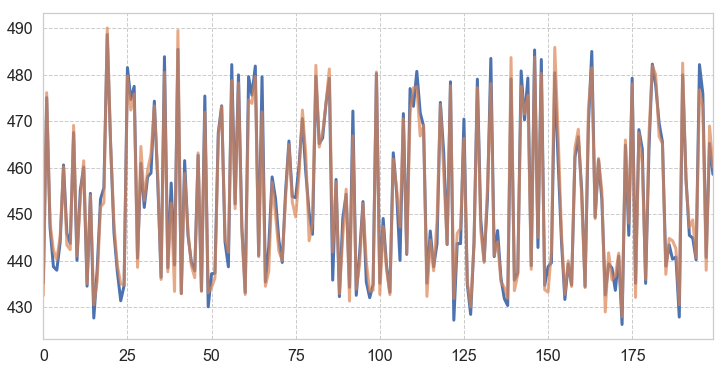

In [32]:
import matplotlib.pyplot as plt 
%matplotlib inline
fig=plt.figure(figsize=(12,6))

y_test[:200].reset_index(drop=True).plot(linewidth=3,fontsize=16)
plt.plot(gsearch2b.best_estimator_.predict(X_test[:200]),linewidth=3,alpha=0.7)

In [33]:
gsearch2b.best_estimator_.feature_importances_

array([0.25180158, 0.25861758, 0.23576747, 0.25381336], dtype=float32)

In [34]:
print_score(gsearch2b.best_estimator_)

RMSE train:  1.1436062080987124
RMSE test:  3.027089488561664
R2 train:  0.9954731391299384
R2 test:  0.9695513290103562


Alleno il modello migliore sull'intero dataset di training

In [35]:
XGB = XGBRegressor(learning_rate=0.1,min_child_weight=5, max_depth=9,n_estimators=400,colsample_bytree=0.7,subsample=0.9,gamma=0.3,
                   nthread=-1,seed=270)

XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
       n_estimators=400, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=270, silent=True, subsample=0.9)

In [37]:
print_score(XGB)

RMSE train:  1.1901734881378003
RMSE test:  3.015431856905374
R2 train:  0.9950969685146606
R2 test:  0.9697853993275205


In [38]:
from joblib import dump,load
import os

directory='models'

if not os.path.exists(directory):
    os.makedirs(directory)

dump(XGB, 'models/XGBoost.joblib') 

['models/XGBoost.joblib']

In [20]:
XGB = XGBRegressor(learning_rate=0.1,min_child_weight=5, max_depth=9,n_estimators=400,colsample_bytree=0.7,subsample=0.9,gamma=0.3,
                   nthread=-1,seed=27)

r2_hist=[]
for bag in range(1,30):
    bags=bag
    seed=1

    bagged_prediction = np.zeros(len(X_test))

    for n in range(0, bags):
        XGB.set_params(seed=seed+n)
        XGB.fit(X_train,y_train)
        preds=XGB.predict(X_test)
        bagged_prediction+=preds

    bagged_prediction/=bags

    r2_hist.append(r2_score(y_test, bagged_prediction))

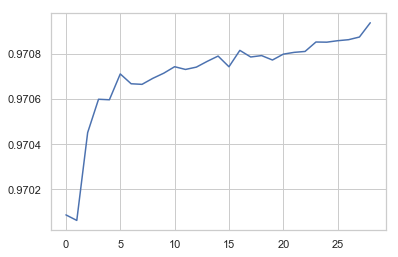

In [21]:
plt.plot(r2_hist)

In [22]:
r2_hist[-1]

0.9709369671375786